In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [4]:
train_df_final.head()

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,humidity_avg_x_dew_depression_evening_X_log_elev,pressure_tendency_X_lat,lat_season_residual,ss_TEMNA_X_lat_season_residual,ss_residual_anomaly_X_slp_avg,lon_temp_interaction,ss_temp_eve_morn_X_lon_temp_interaction,temp_eve_morn_X_humidity_avg,HumDewMorn_X_ClimDoyCos,HumDewEve_X_ClimDoySin
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,0.017213,0.999852,1,9.426812,...,2535.612481,-72.01361,-109.013084,-188.816200,-425.302846,-209.957133,-282.988154,85.156250,-1150.365250,-24.828537
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,0.034422,0.999407,2,9.437325,...,2367.404460,41.69209,-80.203128,-138.141981,1280.548960,-177.813716,-271.614938,106.166667,-1354.149140,-62.440000
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,0.051620,0.998667,3,9.448699,...,2717.066165,15.16076,-99.537609,-187.543225,271.064877,-199.385296,-316.304941,109.684722,-905.048839,-79.416026
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,0.068802,0.997630,4,9.460926,...,581.936697,-329.74653,-53.784601,-117.014989,1073.619070,-148.338430,-266.734331,171.905556,-1083.687350,-21.048499
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,0.085965,0.996298,5,9.473997,...,2748.924496,60.64304,-29.058123,16.351919,1401.274559,-120.750971,41.244309,-4.734722,-935.773580,-130.347977


# Dataset Splitting

In [5]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [6]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 32,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [7]:
study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
study.optimize(objective, n_trials=250, n_jobs=-1)
print("Best trial:")
print(f"  RMSE: {study.best_value:.5f}")
print(f"  Params: {study.best_params}")

best_params = study.best_params.copy()
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 32,
    'verbosity': 0
})

[I 2025-05-13 23:13:17,733] A new study created in memory with name: xgb_reg_opt
[I 2025-05-13 23:14:23,538] Trial 0 finished with value: 1.5163916171169392 and parameters: {'n_estimators': 4279, 'learning_rate': 0.013108711326791393, 'max_depth': 9, 'subsample': 0.8889839474287824, 'colsample_bytree': 0.7990626095260027, 'min_child_weight': 1.8470717022801126, 'gamma': 3.846034861011344, 'reg_alpha': 1.9979035009577903e-07, 'reg_lambda': 0.00023704125918928091}. Best is trial 0 with value: 1.5163916171169392.
[I 2025-05-13 23:14:24,958] Trial 5 finished with value: 1.576560261557249 and parameters: {'n_estimators': 3487, 'learning_rate': 0.05999902026225673, 'max_depth': 15, 'subsample': 0.9907106582389837, 'colsample_bytree': 0.6588303315471025, 'min_child_weight': 1.012013946676556, 'gamma': 0.0004203800073317931, 'reg_alpha': 0.027541208122512314, 'reg_lambda': 3.049548412870092}. Best is trial 0 with value: 1.5163916171169392.
[I 2025-05-13 23:14:27,419] Trial 9 finished with valu

Best trial:
  RMSE: 1.25253
  Params: {'n_estimators': 7686, 'learning_rate': 0.027367337212669172, 'max_depth': 5, 'subsample': 0.5959315110309751, 'colsample_bytree': 0.901155651474499, 'min_child_weight': 0.0072824350924899, 'gamma': 5.136565597520639e-08, 'reg_alpha': 0.00036520349232711184, 'reg_lambda': 4.6466639093441024}


In [8]:
# best_params = {'n_estimators': 7686, 'learning_rate': 0.027367337212669172, 'max_depth': 5, 'subsample': 0.5959315110309751, 'colsample_bytree': 0.901155651474499, 'min_child_weight': 0.0072824350924899, 'gamma': 5.136565597520639e-08, 'reg_alpha': 0.00036520349232711184, 'reg_lambda': 4.6466639093441024}

# Fit

In [9]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.8250 | RMSE: 1.2525


# Feature Importance

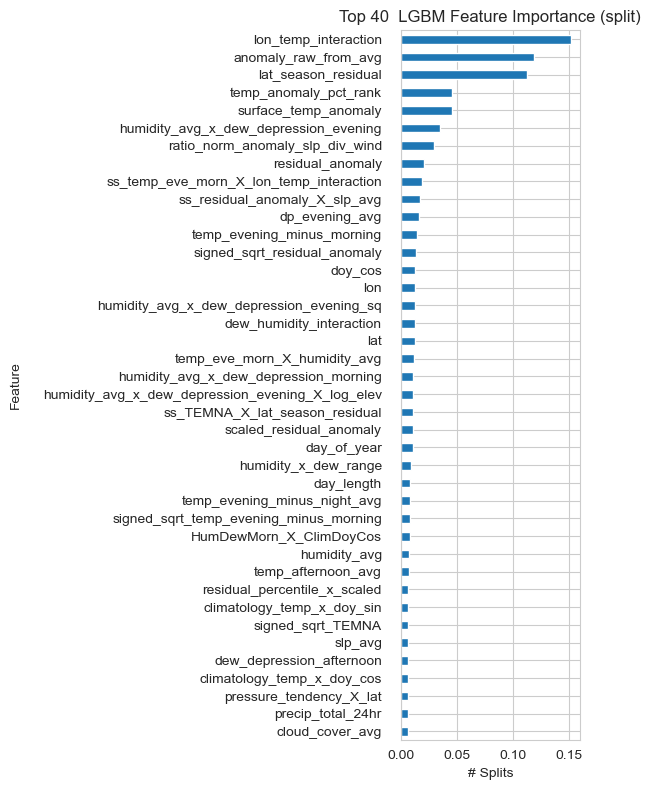

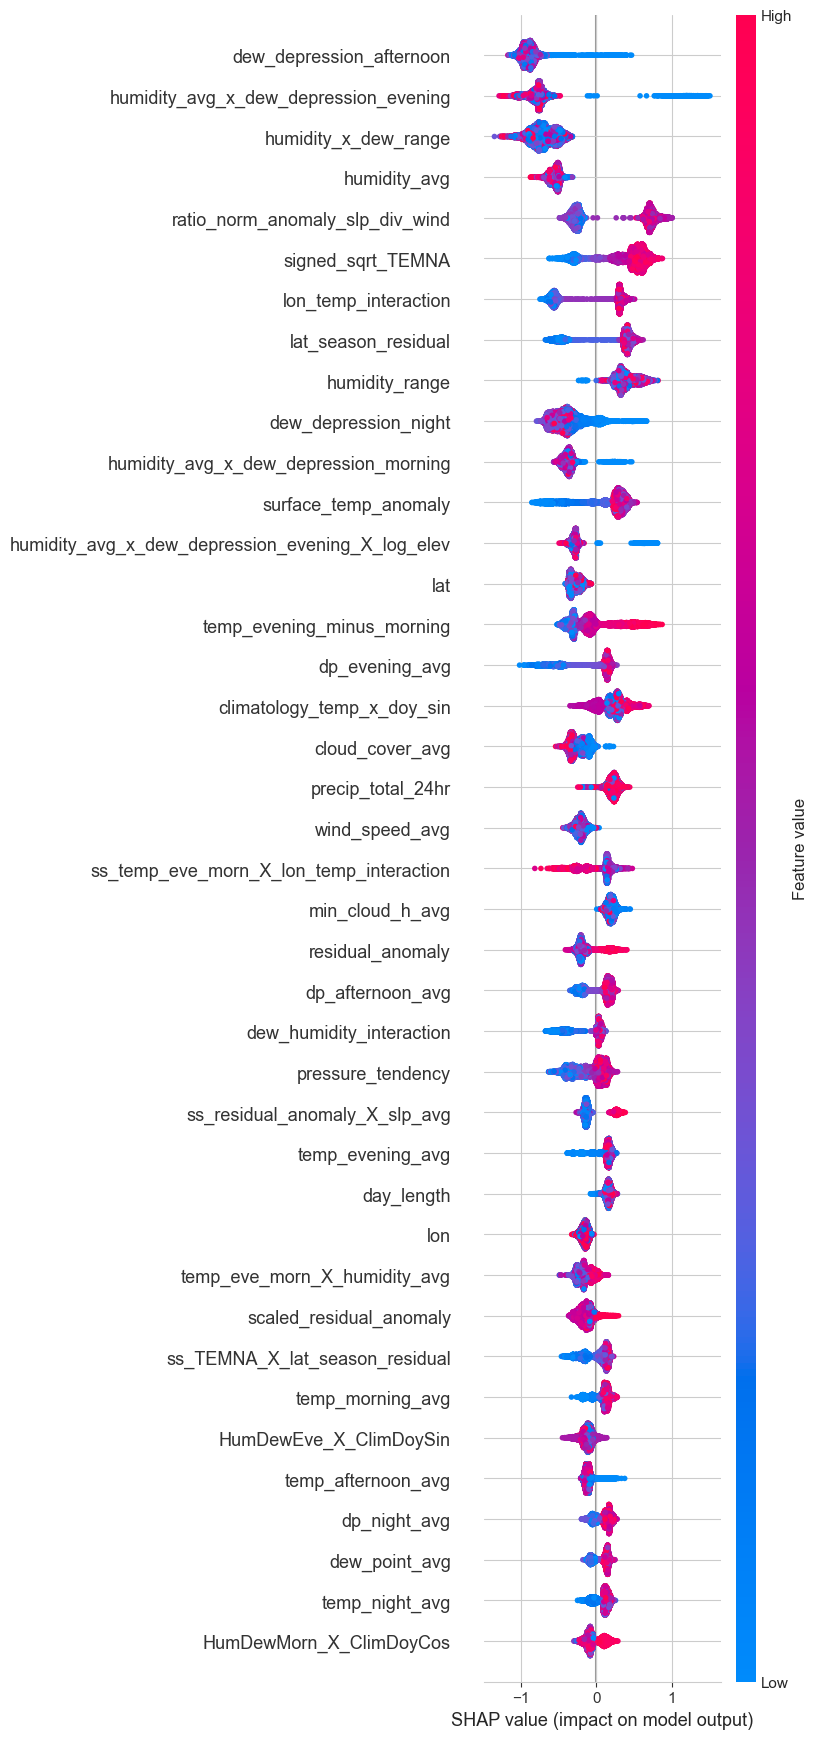

In [10]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 40

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N}  LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [11]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 40 XGB Importances (split):
lon_temp_interaction                                0.152509
anomaly_raw_from_avg                                0.119246
lat_season_residual                                 0.112650
temp_anomaly_pct_rank                               0.045914
surface_temp_anomaly                                0.045554
humidity_avg_x_dew_depression_evening               0.034897
ratio_norm_anomaly_slp_div_wind                     0.029555
residual_anomaly                                    0.020742
ss_temp_eve_morn_X_lon_temp_interaction             0.018614
ss_residual_anomaly_X_slp_avg                       0.016797
dp_evening_avg                                      0.015945
temp_evening_minus_morning                          0.014376
signed_sqrt_residual_anomaly                        0.013451
doy_cos                                             0.012787
lon                                                 0.012730
humidity_avg_x_dew_depression_evening_sq            0

# Feature Selection with SHAP

In [12]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
climatology_temp_x_doy_sin                  0.235119
cloud_cover_avg                             0.228378
precip_total_24hr                           0.222182
wind_speed_avg                              0.215004
ss_temp_eve_morn_X_lon_temp_interaction     0.203178
min_cloud_h_avg                             0.191963
residual_anomaly                            0.191659
dp_afternoon_avg                            0.173659
dew_humidity_interaction                    0.172509
pressure_tendency                           0.165265
ss_residual_anomaly_X_slp_avg               0.161337
temp_evening_avg                            0.159534
day_length                                  0.159475
lon                                         0.156730
temp_eve_morn_X_humidity_avg                0.149512
scaled_residual_anomaly                     0.148591
ss_TEMNA_X_lat_season_residual              0.135094
temp_morning_avg                            0.125892
HumDewEve_X_ClimDoySi

# Predict with Test Dataset

In [13]:
y_test_pred = xgb_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_{now}.csv', index=False)

In [14]:
from sklearn.neural_network import MLPRegressor

X_train_df = pd.DataFrame(X_train, columns=feat_shap_imp.index)
X_val_df = pd.DataFrame(X_val, columns=feat_shap_imp.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=feat_shap_imp.index)

top_features = feat_shap_imp.sort_values(ascending=False).head(top_N).index.tolist()

X_train_top = X_train_df[top_features]
X_val_top = X_val_df[top_features]
X_test_top = X_test_df[top_features]

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_top, y_train)
residuals = y_train - xgb_model.predict(X_train_top)

# Step 2: Fit NN to residuals
res_net = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    alpha=1e-3,
    max_iter=300,
    early_stopping=True,
    random_state=42
)
res_net.fit(X_train_top, residuals)

# Step 3: Predict corrected
y_pred_xgb = xgb_model.predict(X_val_top)
res_correction = res_net.predict(X_val_top)
y_pred = y_pred_xgb + res_correction

r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB + NN R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB + NN R²: 0.8227 | RMSE: 1.2607


In [15]:
y_test_pred = xgb_model.predict(X_test_top) + res_net.predict(X_test_top)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_nn_{now}.csv', index=False)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb

# Prepare data
top_features = feat_shap_imp.sort_values(ascending=False).head(top_N).index.tolist()

X_train_df = pd.DataFrame(X_train, columns=feat_shap_imp.index)
X_val_df = pd.DataFrame(X_val, columns=feat_shap_imp.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=feat_shap_imp.index)

X_train_top = X_train_df[top_features]
X_val_top = X_val_df[top_features]
X_test_top = X_test_df[top_features]

# Step 1: Train XGB
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_top, y_train)
residuals = y_train - xgb_model.predict(X_train_top)

# Convert to tensors
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_top.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_top.values, dtype=torch.float32).to(device)
residual_tensor = torch.tensor(residuals, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# Step 2: Define NN
class ResidualNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

model = ResidualNN(X_train_tensor.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Step 3: Train
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, residual_tensor)
    loss.backward()
    optimizer.step()

# Step 4: Inference
model.eval()
with torch.no_grad():
    xgb_pred = xgb_model.predict(X_val_top)
    nn_corr = model(X_val_tensor).cpu().numpy().flatten()
    final_pred = xgb_pred + nn_corr

# Step 5: Metrics
r2 = r2_score(y_val, final_pred)
rmse = root_mean_squared_error(y_val, final_pred)
print(f"\n✅ XGB + PyTorch NN R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB + PyTorch NN R²: 0.8228 | RMSE: 1.2604


In [17]:
X_test_tensor = torch.tensor(X_test_top.values, dtype=torch.float32).to(device)

y_pred_xgb_test = xgb_model.predict(X_test_top)

residual_correction_test = res_net.predict(X_test_top)

y_pred_test = y_pred_xgb_test + residual_correction_test

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_torch_{now}.csv', index=False)

In [18]:
top_features

['dew_depression_afternoon',
 'humidity_avg_x_dew_depression_evening',
 'humidity_x_dew_range',
 'humidity_avg',
 'ratio_norm_anomaly_slp_div_wind',
 'signed_sqrt_TEMNA',
 'lon_temp_interaction',
 'lat_season_residual',
 'humidity_range',
 'dew_depression_night',
 'humidity_avg_x_dew_depression_morning',
 'surface_temp_anomaly',
 'humidity_avg_x_dew_depression_evening_X_log_elev',
 'lat',
 'temp_evening_minus_morning',
 'dp_evening_avg',
 'climatology_temp_x_doy_sin',
 'cloud_cover_avg',
 'precip_total_24hr',
 'wind_speed_avg',
 'ss_temp_eve_morn_X_lon_temp_interaction',
 'min_cloud_h_avg',
 'residual_anomaly',
 'dp_afternoon_avg',
 'dew_humidity_interaction',
 'pressure_tendency',
 'ss_residual_anomaly_X_slp_avg',
 'temp_evening_avg',
 'day_length',
 'lon',
 'temp_eve_morn_X_humidity_avg',
 'scaled_residual_anomaly',
 'ss_TEMNA_X_lat_season_residual',
 'temp_morning_avg',
 'HumDewEve_X_ClimDoySin',
 'temp_afternoon_avg',
 'dp_night_avg',
 'dew_point_avg',
 'temp_night_avg',
 'HumDewMo

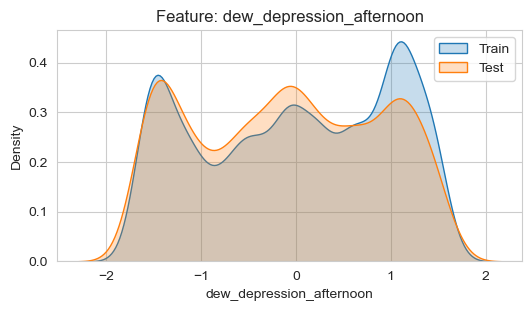

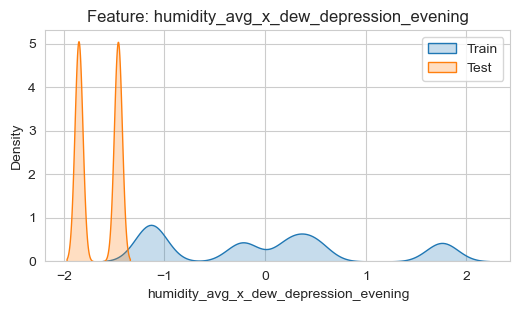

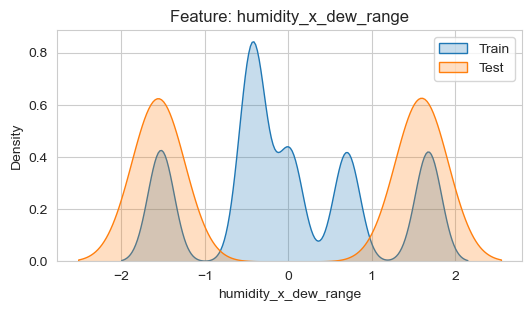

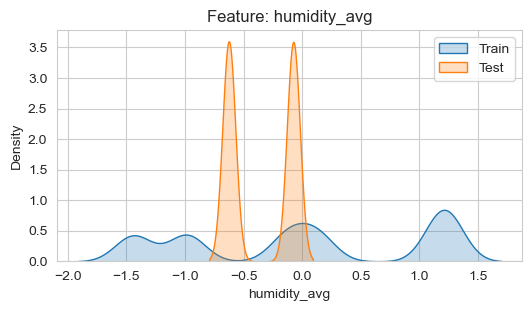

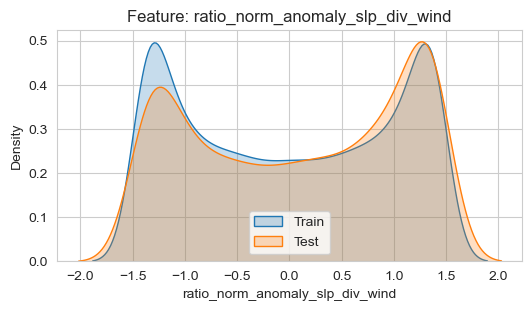

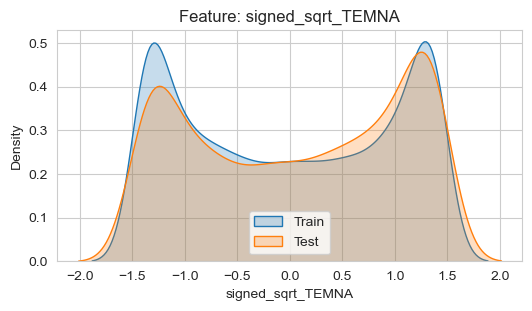

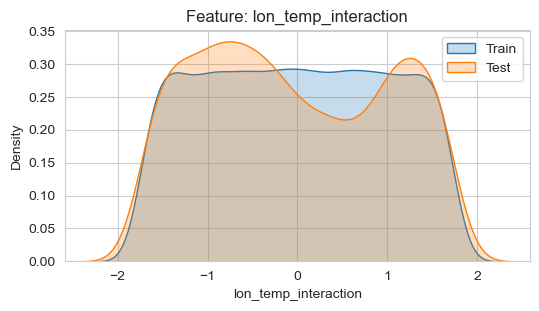

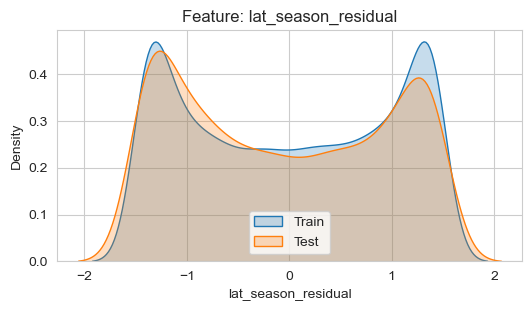

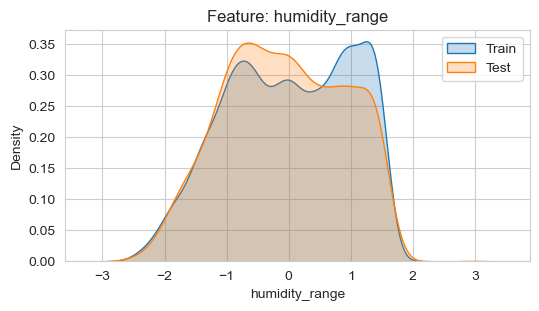

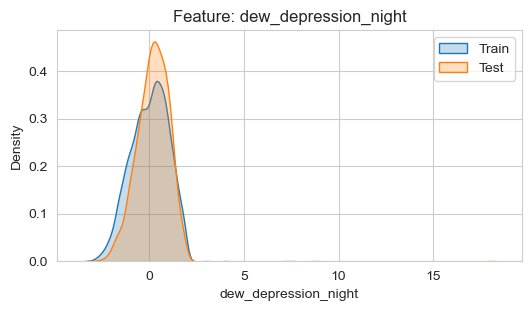

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in top_features[:10]:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(X_train_df[col], label="Train", shade=True)
    sns.kdeplot(X_test_df[col], label="Test", shade=True)
    plt.title(f"Feature: {col}")
    plt.legend()
    plt.show()

In [20]:
train_corrs = X_train_df[top_features].corrwith(pd.Series(y_train, name="target"))
# If you have test target (e.g., CV-split)
test_corrs = X_test_df[top_features].corrwith(pd.Series(y_val, name="target"))

drift = (train_corrs - test_corrs).abs().sort_values(ascending=False)
print("Top correlation drifts:\n", drift.head())

Top correlation drifts:
 dew_point_avg                    0.459689
dp_night_avg                     0.459689
temp_evening_minus_morning       0.459689
ss_residual_anomaly_X_slp_avg    0.265152
cloud_cover_avg                  0.237258
dtype: float64


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_all = pd.concat([X_train_df, X_test_df])
y_domain = np.array([0]*len(X_train_df) + [1]*len(X_test_df))

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_all, y_domain)
probs = clf.predict_proba(X_all)[:, 1]

auc = roc_auc_score(y_domain, probs)
print(f"Train/Test classifier AUC: {auc:.4f}")

Train/Test classifier AUC: 1.0000


In [22]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train_df, y_train)
mi_series = pd.Series(mi, index=X_train_df.columns).sort_values(ascending=False)
print("Top Mutual Info features:\n", mi_series.head(10))

Top Mutual Info features:
 HumDewMorn_X_ClimDoyCos          0.178965
pressure_tendency_signed_sqrt    0.157190
signed_sqrt_TEMNA                0.156373
dp_night_avg                     0.152891
temp_evening_minus_morning       0.152857
dew_point_avg                    0.152825
doy_sin                          0.152249
lon_temp_interaction             0.149798
doy_cos                          0.148089
climatology_temp_x_doy_cos       0.147783
dtype: float64
